# 합성곱 신경망(CNN)

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import sys

path = '/content/drive/MyDrive/deep-learning-from-scratch-master'
os.chdir(path)
sys.path.append(os.chdir)

위에 해당하는 그림은 기존의 Fully Connected Neural Network

아래에 해당하는 그림이 이번에 우리가 알아볼 Convolutional Neural Network

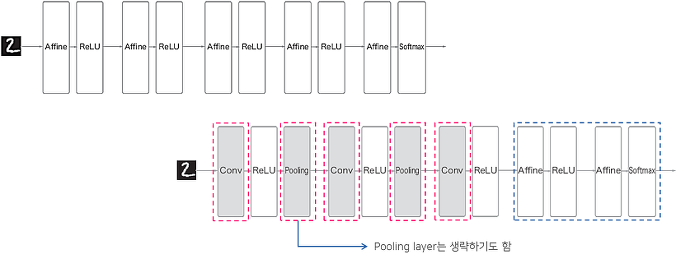

기존의 Fully Connected Neural Network를 vision에 사용하면 아래와 같은 문제들이 있다. 

- Training Time
- Network size
- Number of parameters (파라미터가 많아지면?)

CNN은 신호 처리, 이미지 or 영상 처리, 음성 인식 등 여러 분야에서 사용

# Convolution / Pooling layer 구현

데이터의 형상이 4차원이다 

ex (10, 1, 28, 28)

In [13]:
# batch_size = 10, 3채널 입력 데이터
x = np.random.rand(10, 3, 28, 28)
print(x.shape)

(10, 3, 28, 28)


In [14]:
# 각각이 이미지라고 생각
print(x[0].shape)
print(x[1].shape)

print(x[0,0].shape) # 첫 데이터의 첫 채널 값들(28, 28)

(3, 28, 28)
(3, 28, 28)
(28, 28)


im2col은 입력 데이터를 필터링(가중치 계산)이 수월하게 행렬로 전개해준다

3차원 입력 데이터를 2차원으로 변환

(배치 안의 데이터 수까지 포함하면 4차원인데 4차원을 2차원으로 변환)

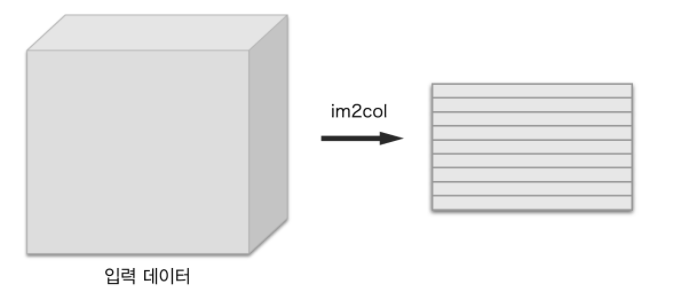

스트라이드를 일부러 필터 적용이 안겹치게 지정하지 않는 이상 일반적으로 필터 영역이 겹친다.

필터 적용 영역이 겹치게 되면 원래 입력 데이터의 원소 수보다 2D로 전개한 데이터의 원소 수가 더 많아짐

=> 메모리를 더 많이 차지한다.

=> 그래도 계산이 빠르다. 따라서 바꿀거다.

그 다음은 FN개의 필터를 세로로 1열로 전개해 2D로 만든 다음에

입력 데이터와 행렬 곱 연산 => 2차원 출력 데이터 

2차원 출력 데이터를 3차원으로( 배치 고려하면 4차원으로 ) 

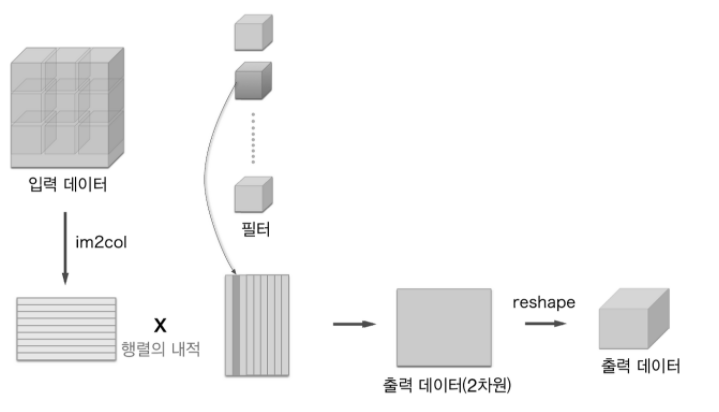

im2col의 반환값 shape를 (H, W)라 하면 

N = 입력 데이터 수, OH = 출력 높이, OW = 출력 너비

CH = 채널 수, FH = 필터 높이, HW = 필터 너비
일 때,

- H = N * OH * OW
- W = CH * FH * FW

In [15]:
from common.util import im2col

x1 = np.random.rand(1, 3, 7, 7) # 데이터 수 1개, 3채널 7*7
col1 = im2col(x1, 5, 5, stride = 1, pad = 0)
print(col1.shape)

x2 = np.random.rand(10, 3, 7, 7) # 데이터 수 10개, 3채널 7*7
col2 = im2col(x2, 5, 5, stride = 1, pad = 0)
print(col2.shape)

(9, 75)
(90, 75)


im2col을 사용해 Convolution Layer를 구현해보자.

In [16]:
class Convolution(object):
    def __init__(self, W, b, stride = 1, pad = 0):
        self.W = W # filter 
        self.b = b # bias
        self.stride = stride
        self.pad = pad

    def forward(self, x):
        FN, C, FH, FW = self.W.shape # 필터는 4차원
        N, C, H, W = x.shape

        # 수식 이용
        out_h = 1 + (H + 2*self.pad - FH) // self.stride 
        out_w = 1 + (W + 2*self.pad - FW) // self.stride

        col = im2col(x, FH, FW, self.stride, self.pad) # 입력 데이터를 2D로
        col_W = self.W.reshape(FN, -1).T # 필터를 세로로 1열로 전개해 2D로
        
        out = np.dot(col, col_W) + self.b # 행렬 곱 + 편향
        
        out = out.reshape(N, out_h,out_w, -1).transpose(0, 3, 1, 2)

        return out        

한번 사용해봅시다.

In [17]:
x2 = np.random.rand(10, 3, 7, 7) # 데이터 수 10개, 3채널 7*7
# 필터 높이 = 5 필터 너비 = 5
col2 = im2col(x2, 5, 5, stride = 1, pad = 0) 

# 필터 기준으로 봅시다. (위는 입력 데이터)
FN = 10
# 채널3 필터 높이=5 필터 너비=5
W = np.random.randn(FN, 3, 5, 5) 
col_W = W.reshape(FN, -1).T
print(col_W.shape)

b = np.random.randn(FN, 1, 1)

(75, 10)


In [18]:
layer1 = Convolution(W, b)

out = layer1.forward(x2)
print(out.shape)

(10, 100, 3, 3)


역전파 같은 경우는 따로 구현하지는 않겠으나, Affine 계층의 역전파와 매우 유사함.

im2col이 forward에 들어갔으니까

backward에는 반대로 col2im을 사용하는 점 주의

다음은 im2col을 사용해 Pooling Layer 구현하기

정확히는 Max Pooling

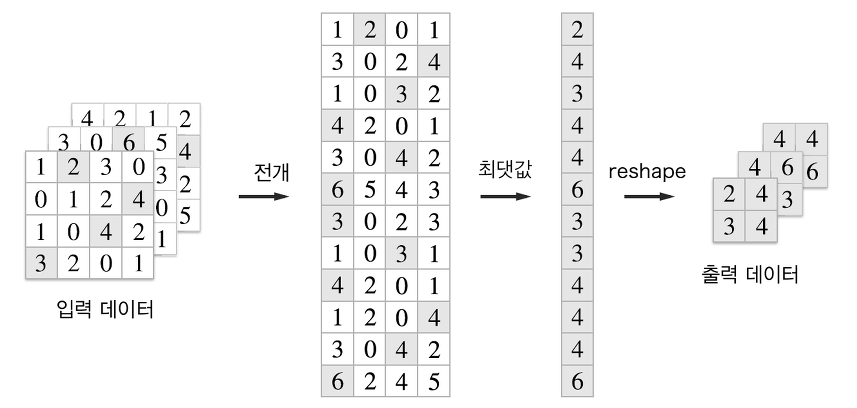

In [19]:
class Pooling(object):
    def __init__(self, pool_h, pool_w, stride = 1, pad = 0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad

    def forward(self, x):
        N, C, H, W = x.shape
        out_h = 1 + (H  + 2*self.pad + self.pool_h) // self.stride
        out_w = 1 + (W + 2*self.pad + self.pool_h) // self.stride

        # 전개 과정
        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        col = col.reshape(-1, self.pool_h * self.pool_w)

        # 최댓값
        out = np.max(col, axis = 1)

        # reshape
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)
        
        return out

# CNN 구현하기


앞에서 Convolution Layer, Pooling Layer를 구현했음

계층들을 조합해서 처음에 본 그림처럼 CNN을 구현해보자.

In [20]:
from common.layers import Relu, SoftmaxWithLoss, Affine
from common.layers import Convolution, Pooling

class SimpleConvNet(object):
    def __init__(self, input_dim= (1, 28, 28), 
                 conv_param = {'filter_num' : 30, 'filter_size' : 5, 'pad' : 0, 'stride' : 1}, 
                 hidden_size = 100, output_size = 10, weight_init_std = 0.01):
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        input_size = input_dim[1]
        conv_output_size = 1 + (input_size - filter_size + 2*filter_pad) // filter_stride
        pool_output_size = filter_num * (conv_output_size//2) * (conv_output_size//2) # 2*2 풀링 CH = 1 기준

        # 가중치 매개변수 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
        self.params['b1'] = np.zeros(filter_num)
        self.params['W2'] = weight_init_std * np.random.randn(pool_output_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)

        self.layers = {}
        self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'], conv_param['stride'], conv_param['pad'])
        self.layers['Relu1'] = Relu()
        self.layers['Pool1'] = Pooling(pool_h = 2, pool_w = 2, stride = 2)
        self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W3'], self.params['b3'])

        self.last_layer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        return x
                          

    def loss(self, x, t):
        y = self.predict(x)

        return self.last_layer.forward(y, t)


    def gradient(self, x, t):
        self.loss(x,t)

        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        grads = {}
        grads['W1'] = self.layers['Conv1'].dW
        grads['b1'] = self.layers['Conv1'].db
        grads['W2'] = self.layers['Affine1'].dW
        grads['b2'] = self.layers['Affine1'].db
        grads['W3'] = self.layers['Affine2'].dW
        grads['b3'] = self.layers['Affine2'].db

        return grads

    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        acc = 0.0
        
        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt) 
        
        return acc / x.shape[0]

In [21]:
# 예시 class 사용 x

# 입력 데이터 기준
batch_size = 10 
C, H, W = 1, 7, 7

input_dim = (batch_size, C, H, W)
x1 = np.random.randn(input_dim[0], input_dim[1], input_dim[2], input_dim[3])

# hyper parameter
FN = 10 # filter_num
filter_size = 4
pad = 0
stride = 1

conv_output_size = 1 + (H - filter_size + 2*pad) // stride
print(conv_output_size)

pool_output_size = FN * (conv_output_size/2) * (conv_output_size/2)
print(pool_output_size)

4
40.0


학습시켜봅시다. (프레임워크 실습으로 넘어갑시다..)